# Collaborative Filtering

## Import fastai

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

# Data Analysis

Note: this dataset uses a subset of the 100,000 movie rankings.

In [2]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [11]:
ratings.count()

user         100000
movie        100000
rating       100000
timestamp    100000
dtype: int64

Understanding latent factors

In [13]:
the_force_awakens = np.array([0.98,0.9,-0.9])

In [4]:
user_1 = np.array([0.9,0.8,-0.6])

In [5]:
(user1*the_force_awakens).sum()

2.1420000000000003

In [8]:
a_star_is_born = np.array([-0.99,-0.3,0.8])

In [9]:
(user1*a_star_is_born).sum()

-1.611

# DataLoaders

In [14]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [15]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [16]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,183,Heat (1995),4
1,115,"Good, The Bad and The Ugly, The (1966)",5
2,272,Terminator 2: Judgment Day (1991),5
3,854,Lawrence of Arabia (1962),4
4,527,Ben-Hur (1959),5
5,296,To Gillian on Her 37th Birthday (1996),2
6,733,Things to Do in Denver when You're Dead (1995),1
7,15,"Edge, The (1997)",3
8,389,Gigi (1958),5
9,627,Courage Under Fire (1996),3


In [17]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [48]:
# Understanding pytorch definiton of latent factors

n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [19]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

Model input tensor

In [20]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [23]:
y.shape

torch.Size([64, 1])

# Model 

In [24]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [25]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.333427,1.284461,00:18
1,1.051597,1.076939,00:18
2,0.997475,0.966109,00:17
3,0.819778,0.878681,00:17
4,0.779175,0.860289,00:17


# sigmoid_range

In [26]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

Run 2

In [27]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.990298,0.993584,00:15
1,0.877516,0.898700,00:16
2,0.694732,0.860205,00:17
3,0.483860,0.863093,00:16
4,0.397027,0.867936,00:17


# Function to add biases (user, movie)

In [28]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

Run 3

In [29]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.946077,0.927626,00:19
1,0.818836,0.850645,00:18
2,0.611833,0.852969,00:19
3,0.406145,0.878546,00:19
4,0.295636,0.884371,00:19


# L2 Regularization, weighted decay 

In [30]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.965195,0.933673,00:19
1,0.865558,0.865177,00:18
2,0.733653,0.823934,00:19
3,0.575310,0.809172,00:19
4,0.491069,0.809653,00:19


In [33]:
# To create squeeze

class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [34]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [35]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[ 0.1726],
        [-0.2923],
        [ 0.2101]], requires_grad=True)]

In [36]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [37]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [38]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [39]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.923929,0.923432,00:17
1,0.846672,0.860228,00:18
2,0.730091,0.821746,00:18
3,0.587416,0.812498,00:18
4,0.473547,0.813374,00:18


*Squeeze

# Interpreting embeddings

In [42]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:10]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Robocop 3 (1993)',
 'Bio-Dome (1996)',
 'Bloodsport 2 (1995)',
 'Amityville: A New Generation (1993)',
 '3 Ninjas: High Noon At Mega Mountain (1998)',
 'Cable Guy, The (1996)',
 'Showgirls (1995)']

In [44]:
idxs = movie_bias.argsort(descending=True)[:10]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Titanic (1997)',
 "Schindler's List (1993)",
 'Star Wars (1977)',
 'Usual Suspects, The (1995)',
 'Rear Window (1954)',
 'Good Will Hunting (1997)',
 'Silence of the Lambs, The (1991)',
 'To Kill a Mockingbird (1962)']

# PCA 

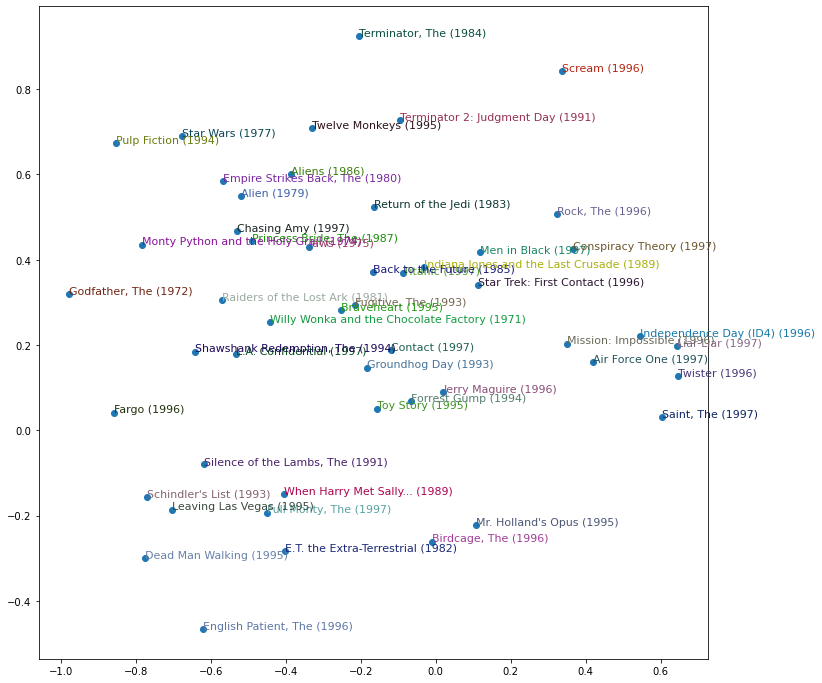

In [52]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))


X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()